## 루브릭
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	
 - 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
 - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
 - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
3.8.3


In [2]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import glob
import matplotlib.pyplot as plt
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(15)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

{텍스트:인덱스} 구조로 변경

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
print(X_train[99])
print(get_decoded_sentence(X_train[1], index_to_word))
print('라벨: ', y_train[1])

[445, 34, 7, 826, 1666, 55, 41, 3789, 66, 3, 116, 12, 34, 30]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1


## 3) 모델 구성을 위한 데이터 분석 및 가공

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 정규분포 기준 2시그마  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- padding에 pre와 post가 있다고 하는데 문장의 끝부분에 중요한 정보를 담고 있기 때문에 뒤쪽을 padding하는 post가 아닌 앞쪽을 패딩하는 pre로 진행

In [8]:
word_to_index['<PAD>'] = 0

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성



In [10]:
# validation set 10000건 분리
x_val = X_train[:44000]   
y_val = y_train[:44000]

# validation set을 제외한 나머지 15000건
x_train = X_train[44000:]  
y_train = y_train[44000:]

print(x_train.shape)
print(y_train.shape)

(102182, 41)
(102182,)


X_train의 30프로(43854 -> 44000)를 validation set으로 지정

### 모델구성

 - RNN(LSTM)
 - 1D CNN
 - GlobalMaxPooling1D

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [13]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

hist_rnn = model_rnn.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

hist_cnn = model_cnn.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

hist_gmp = model_gmp.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
1597/1597 [==============================] - 12s 6ms/step - loss: 0.4087 - accuracy: 0.8161 - val_loss: 0.3473 - val_accuracy: 0.8496
Epoch 2/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.3251 - accuracy: 0.8629 - val_loss: 0.3398 - val_accuracy: 0.8509
Epoch 3/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.2968 - accuracy: 0.8744 - val_loss: 0.3472 - val_accuracy: 0.8507
Epoch 4/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.2711 - accuracy: 0.8858 - val_loss: 0.3496 - val_accuracy: 0.8539
Epoch 5/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.2464 - accuracy: 0.8966 - val_loss: 0.3573 - val_accuracy: 0.8526
Epoch 6/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.2239 - accuracy: 0.9064 - val_loss: 0.3785 - val_accuracy: 0.8507
Epoch 7/10
1597/1597 [==============================] - 9s 5ms/step - loss: 0.2063 - accuracy: 0.9152 - val_loss: 0.3976 - val_accuracy

## 5) 모델 훈련 개시

In [15]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print("rnn : ", results_rnn)
print("cnn : ", results_cnn)
print("gmp : ", results_gmp)

1537/1537 - 3s - loss: 0.5022 - accuracy: 0.8416
1537/1537 - 2s - loss: 0.7400 - accuracy: 0.8239
1537/1537 - 2s - loss: 0.4769 - accuracy: 0.8266
rnn :  [0.5022367238998413, 0.8415688276290894]
cnn :  [0.7399734258651733, 0.8238908052444458]
gmp :  [0.4769218862056732, 0.8266167640686035]


## 6) Loss, Accuracy 그래프 시각화

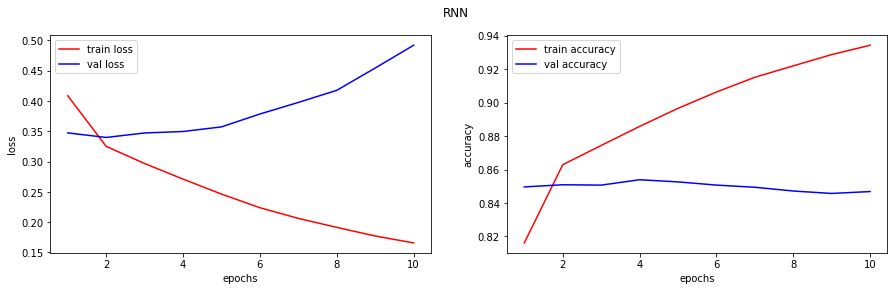

In [16]:
%matplotlib inline
plt.figure(figsize=(15,4))
plt.suptitle('RNN')
epochs = range(1, len(hist_rnn.history['accuracy']) + 1)

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, hist_rnn.history['loss'], 'r', label = 'train loss')
plt.plot(epochs, hist_rnn.history['val_loss'], 'b', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, hist_rnn.history['accuracy'], 'r', label='train accuracy')
plt.plot(epochs, hist_rnn.history['val_accuracy'], 'b', label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

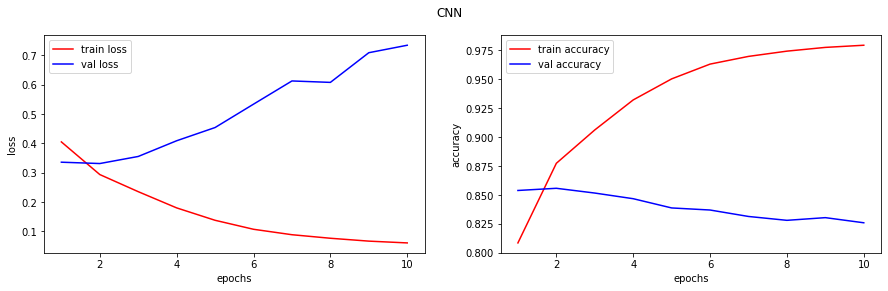

In [17]:
%matplotlib inline
plt.figure(figsize=(15,4))
plt.suptitle('CNN')
epochs = range(1, len(hist_rnn.history['accuracy']) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, hist_cnn.history['loss'], 'r', label = 'train loss')
plt.plot(epochs, hist_cnn.history['val_loss'], 'b', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist_cnn.history['accuracy'], 'r', label='train accuracy')
plt.plot(epochs, hist_cnn.history['val_accuracy'], 'b', label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

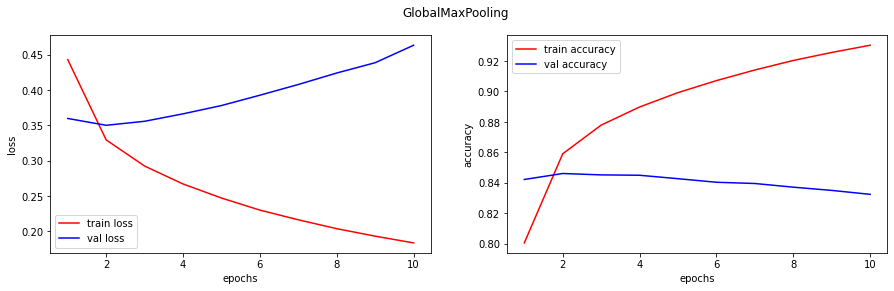

In [18]:
%matplotlib inline
plt.figure(figsize=(15,4))
plt.suptitle('GlobalMaxPooling')
epochs = range(1, len(hist_rnn.history['accuracy']) + 1)

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, hist_gmp.history['loss'], 'r', label = 'train loss')
plt.plot(epochs, hist_gmp.history['val_loss'], 'b', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, hist_gmp.history['accuracy'], 'r', label='train accuracy')
plt.plot(epochs, hist_gmp.history['val_accuracy'], 'b', label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = model_rnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('전해', 0.9573622345924377),
 ('참신', 0.949296236038208),
 ('사수', 0.9473133683204651),
 ('일깨워', 0.940320611000061),
 ('정점', 0.9401550889015198),
 ('순수', 0.9354608058929443),
 ('의외', 0.9328314065933228),
 ('추천', 0.9321061372756958),
 ('큐', 0.9308414459228516),
 ('명화', 0.9299296736717224)]

In [22]:
word_vectors.similar_by_word("이별")

[('오묘', 0.9618671536445618),
 ('손잡', 0.9591883420944214),
 ('젊음', 0.9378917217254639),
 ('무상', 0.9377568960189819),
 ('귀여우', 0.9239509105682373),
 ('느꼈', 0.9216328263282776),
 ('롤', 0.9210737943649292),
 ('쩐', 0.9202361106872559),
 ('무협', 0.9198287129402161),
 ('거울', 0.912383496761322)]

In [23]:
word_vectors.similar_by_word("성공")

[('무게', 0.9248569011688232),
 ('최강희', 0.9245568513870239),
 ('템포', 0.9219479560852051),
 ('브라이언', 0.9157190322875977),
 ('넘치', 0.9144980907440186),
 ('특별', 0.9132179617881775),
 ('맘', 0.9122899174690247),
 ('모세', 0.9116474390029907),
 ('제시', 0.9094777703285217),
 ('당함', 0.9094759225845337)]

- 상당히 부자연스럽다

In [24]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']

/tmp/ipykernel_407/913311597.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [25]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("성공")

/tmp/ipykernel_407/2370447260.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("성공")


[('실패', 0.6856883764266968),
 ('대성공', 0.6117161512374878),
 ('주력', 0.5659711360931396),
 ('압승', 0.5545106530189514),
 ('흥행', 0.49906763434410095),
 ('공헌', 0.4934632182121277),
 ('성공적', 0.48284801840782166),
 ('승리', 0.46511217951774597),
 ('진력', 0.4633210301399231),
 ('그치', 0.4610019326210022)]

In [26]:
word2vec.similar_by_word("이별")

/tmp/ipykernel_407/1195740980.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("이별")


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

- 확실히 아까보다 단어와 비슷한 부류, 느낌으로 나타내는 것을 볼 수 있다.

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_407/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_407/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [38]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1597/1597 [==============================] - 11s 6ms/step - loss: 0.4341 - accuracy: 0.7982 - val_loss: 0.3636 - val_accuracy: 0.8392
Epoch 2/5
1597/1597 [==============================] - 10s 6ms/step - loss: 0.3307 - accuracy: 0.8599 - val_loss: 0.3350 - val_accuracy: 0.8537
Epoch 3/5
1597/1597 [==============================] - 9s 6ms/step - loss: 0.2952 - accuracy: 0.8775 - val_loss: 0.3297 - val_accuracy: 0.8595
Epoch 4/5
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2680 - accuracy: 0.8909 - val_loss: 0.3359 - val_accuracy: 0.8590
Epoch 5/5
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2444 - accuracy: 0.9009 - val_loss: 0.3420 - val_accuracy: 0.8604


In [40]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3580 - accuracy: 0.8526
[0.35799795389175415, 0.8525744080543518]


- 정확도 : 85%이상이 나왔다

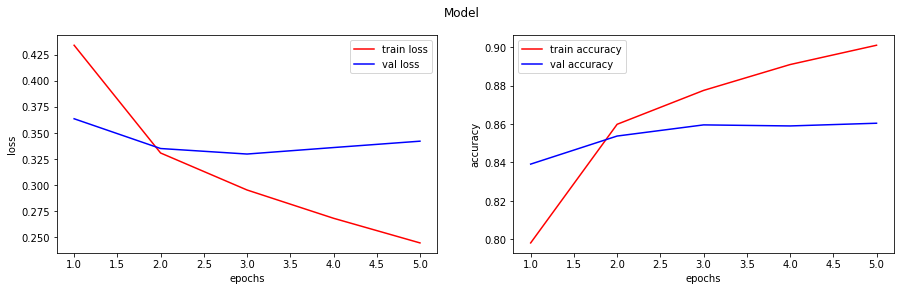

In [43]:
%matplotlib inline
plt.figure(figsize=(15,4))
plt.suptitle('Model')
epochs = range(1, len(history.history['accuracy']) + 1)

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, history.history['loss'], 'r', label = 'train loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, history.history['accuracy'], 'r', label='train accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

# 회고
 - 어.. 생각보다 쉽지않았다...
  